In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

# numpy基础
数据处理库。核心是多维数组NDarray
底层使用C实现，效率高。

## NDArray
numpy中最重要的类。多维数据包装器

多维数组的创建、修改以及多维数组的属性

### 创建
从数组创建或使用内置函数

In [3]:
arr1 = np.array([1, 2, 3, 4, 5])
arr2 = np.zeros([2, 2, 3], dtype = np.float32)
arr3 = np.ones([2, 2])
print(arr1, type(arr1))
print(arr2)
print(arr3)

[1 2 3 4 5] <class 'numpy.ndarray'>
[[[0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]]]
[[1. 1.]
 [1. 1.]]


### 修改
主要包括维度变换和拼接

In [4]:
arr1 = np.zeros([1, 1, 4],  dtype=np.int32)
arr2 = np.ones([5, 1, 4], dtype=np.int32)
arr = np.concatenate([arr1, arr2], axis=0)
print('concatenate:', arr)

print('expand1:', np.expand_dims(arr1, 3))
print('expand2', arr2[ :, :, np.newaxis, :])

concatenate: [[[0 0 0 0]]

 [[1 1 1 1]]

 [[1 1 1 1]]

 [[1 1 1 1]]

 [[1 1 1 1]]

 [[1 1 1 1]]]
expand1: [[[[0]
   [0]
   [0]
   [0]]]]
expand2 [[[[1 1 1 1]]]


 [[[1 1 1 1]]]


 [[[1 1 1 1]]]


 [[[1 1 1 1]]]


 [[[1 1 1 1]]]]


### 获取数组属性

In [5]:
arr = np.array([[1, 1, 4, 5, 1, 4], [1, 9, 1, 9, 8, 10]])
print('size:', arr.size)
print('shape:', arr.shape)

size: 12
shape: (2, 6)


### 切片和筛选
切片和python list一致



In [6]:
arr = np.array([[1, 1, 4, 5, 1], 
                [4, 1, 9, 1, 9],
                [8, 1, 0, 1, 1], 
                [4, 5, 1, 4, 1], 
                [9, 1, 9, 8, 10]])

print('single choose')
print(arr[1])
print(arr[1, 0])
print(arr[[1, 0], [2, 3]])

print('slice')
print(arr[:2, :3])

print('filter')
print(arr>5)
print(arr[arr>7])



single choose
[4 1 9 1 9]
4
[9 5]
slice
[[1 1 4]
 [4 1 9]]
filter
[[False False False False False]
 [False False  True False  True]
 [ True False False False False]
 [False False False False False]
 [ True False  True  True  True]]
[ 9  9  8  9  9  8 10]


### np.where
按条件选择、替换数据

In [7]:
condition = arr>5
print(condition)
print(np.where(condition, -1, arr))
print(np.where(condition, -1, 2))
rra = -arr
print(np.where(condition, arr, rra))

[[False False False False False]
 [False False  True False  True]
 [ True False False False False]
 [False False False False False]
 [ True False  True  True  True]]
[[ 1  1  4  5  1]
 [ 4  1 -1  1 -1]
 [-1  1  0  1  1]
 [ 4  5  1  4  1]
 [-1  1 -1 -1 -1]]
[[ 2  2  2  2  2]
 [ 2  2 -1  2 -1]
 [-1  2  2  2  2]
 [ 2  2  2  2  2]
 [-1  2 -1 -1 -1]]
[[-1 -1 -4 -5 -1]
 [-4 -1  9 -1  9]
 [ 8 -1  0 -1 -1]
 [-4 -5 -1 -4 -1]
 [ 9 -1  9  8 10]]


## 数据保存和加载
```python
numpy.save(file, arr, allow_pickle=True, fix_imports=True)
```
- file：要保存的文件，扩展名为 .npy，如果文件路径末尾没有扩展名 .npy，该扩展名会被自动加上。
- arr: 要保存的数组

```python
numpy.savez(file, *args, **kwds)
```
- file：要保存的文件，扩展名为 .npz，如果文件路径末尾没有扩展名 .npz，该扩展名会被自动加上。
- args: 要保存的数组，可以使用关键字参数为数组起一个名字，非关键字参数传递的数组会自动起名为 arr_0, arr_1, …　。
- kwds: 要保存的数组使用关键字名称。

In [8]:
# 保存
a = np.array([1, 1, 4, 5, 1, 4])
b = np.array([[1, 9, 1], [9, 8, 10]])

np.save("result/a", a)
np.savez("result/ab", a=a, b=b)

In [9]:
# 加载
a = np.load('result/a.npy')
ab = np.load('result/ab.npz')

print(a)
print(ab)
print(ab['a'])
print(ab['b'])

[1 1 4 5 1 4]
NpzFile 'result/ab.npz' with keys: a, b
[1 1 4 5 1 4]
[[ 1  9  1]
 [ 9  8 10]]


## Broadcast
一种自动复制填充机制，使得原本形状不同的两个array能够进行原本只有两相同形状array才能进行的操作。

广播的规则如下：

1. 从后向前，如果两数组对应维度上轴的长度相同或其中一个的轴长度为1，广播兼容，可在轴长度为1的轴上进行广播机制处理。
2. 如果两个数组的维度不同导致某个数组的前方没有维度，那么给低维度的数组前扩展提升一维，扩展维的轴长度为1,然后在扩展出的维上进行广播机制处理。

In [10]:
'''
a: (3, 5)
b: (5)

1. extend b into (1, 5)
2. copy b in dim 0 to (3, 5)
'''
a = np.arange(1, 16).reshape([3, 5])
print(a)
b = np.array([2, 3, 4, 5, 6])
print(b)
print(a+b)

[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]]
[2 3 4 5 6]
[[ 3  5  7  9 11]
 [ 8 10 12 14 16]
 [13 15 17 19 21]]


In [11]:
"""
2: ()
a: (3, 5)

1. extend 2 into (1)
2. copy 2 in dim 0 to (5)
3. extend 2 into (1, 5)
4. copy 2 in dim 0 to (3, 5)
"""

a = np.arange(1, 16).reshape([3, 5])
print(2 * a)

[[ 2  4  6  8 10]
 [12 14 16 18 20]
 [22 24 26 28 30]]


In [12]:
'''
a: (1, 5)
b: (3, 4, 1)

1. copy b in dim 2 to (3, 4, 5)
2. copy a in dim 0 to (4, 5)
3. extend a into (1, 4, 5)
4. copy a in dim 0 to (3, 4, 5)
'''

a = np.arange(1, 5)
b = np.arange(0, 12).reshape((3, 4, 1))
print(a + b)

[[[ 1  2  3  4]
  [ 2  3  4  5]
  [ 3  4  5  6]
  [ 4  5  6  7]]

 [[ 5  6  7  8]
  [ 6  7  8  9]
  [ 7  8  9 10]
  [ 8  9 10 11]]

 [[ 9 10 11 12]
  [10 11 12 13]
  [11 12 13 14]
  [12 13 14 15]]]


## 线性代数

In [13]:
# 矩阵和向量积
a = np.random.randint(5, size=(3, 3))
b = np.random.randint(5, size = (3, 3))

print(f'a:{a}\nb:{b}')

# dot根据不同情况选择，1维数组为内积，2维数组为矩阵乘，其他情况请阅读文档
print(f'dot:\n {np.dot(a, b)}')
# vdot计算逐元素乘积并求和
print(f"vdot:\n {np.vdot(a, b)}")
# inner 计算最后一维内积
print(f"inner:\n {np.inner(a, b)}")
# 展开后算ab^T
print(f"outer:\n {np.outer(a, b)}")
# matmul计算矩阵乘
print(f"outer:\n {a@b}")

a:[[4 3 1]
 [0 0 1]
 [3 2 3]]
b:[[1 3 4]
 [0 3 0]
 [4 3 4]]
dot:
 [[ 8 24 20]
 [ 4  3  4]
 [15 24 24]]
vdot:
 47
inner:
 [[17  9 29]
 [ 4  0  4]
 [21  6 30]]
outer:
 [[ 4 12 16  0 12  0 16 12 16]
 [ 3  9 12  0  9  0 12  9 12]
 [ 1  3  4  0  3  0  4  3  4]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 1  3  4  0  3  0  4  3  4]
 [ 3  9 12  0  9  0 12  9 12]
 [ 2  6  8  0  6  0  8  6  8]
 [ 3  9 12  0  9  0 12  9 12]]
outer:
 [[ 8 24 20]
 [ 4  3  4]
 [15 24 24]]


### Einstein Notation
$a_i b_i = \sum_{i} a_i b_i$

$a_{ij}b_{jk} = \sum_{j}a_{ij}b_{jk}$


In [14]:
import torch
a = np.arange(0, 9).reshape(3, 3)
print(a)
print(np.einsum("ij->ji", a))


A = torch.tensor(np.random.randint(5, size=(2, 2, 2, 5))).reshape(2, 2, 1, 2, 5)
B = torch.tensor(np.random.randint(5, size=(2, 2, 2, 5))).reshape(2, 1, 2, 2, 5)
"""
想将两者的第2个维度分别reshape为2x1和1x2的两个向量，然后计算外积，得到一个2x2的kernel
"""
print(A.shape, B.shape)
res = torch.einsum(
    "ijk...,iko...->ijo...", [A, B]
)
print(res.shape)

[[0 1 2]
 [3 4 5]
 [6 7 8]]
[[0 3 6]
 [1 4 7]
 [2 5 8]]
torch.Size([2, 2, 1, 2, 5]) torch.Size([2, 1, 2, 2, 5])
torch.Size([2, 2, 2, 2, 5])


## numpy使用原则
尽量向量化所有操作，让numpy可以自动并行

1. 减少遍历操作
2. 尽量使用内置方法和函数
3. 善用广播

In [15]:
import time

s_time = time.time()
a = np.array([i for i in range(1919810)])
print(time.time()-s_time)

s_time = time.time()
a = np.linspace(0, 1919810, 1919811)
print(time.time() - s_time)

0.15205979347229004
0.004002809524536133


In [16]:
a = np.random.random(1919810)
b = np.random.random(1919810)

s_time = time.time()
print(a@b)
print(time.time() - s_time)

s_time = time.time()
res = 0
for i in range(len(a)):
    res += a[i]*b[i]
print(res)
print(time.time() - s_time)

479739.5130717429
0.006452083587646484
479739.51307174336
0.37381935119628906


In [17]:
samples = np.random.random((1145, 14))



s_time = time.time()

dists = []
for p1 in samples:
    for p2 in samples:
        dists.append(np.linalg.norm(p1-p2))
print(np.mean(dists))

print(time.time() - s_time)

s_time = time.time()

diff = samples[:, np.newaxis, :] - samples[np.newaxis, :, :]
dist = np.linalg.norm(diff, axis = -1)
print(np.mean(dist))

print(time.time() - s_time)

1.5007627953055451
2.6169955730438232
1.5007627953055451
0.11053109169006348


# Matplotlib绘图
以曲线为例
## 基础

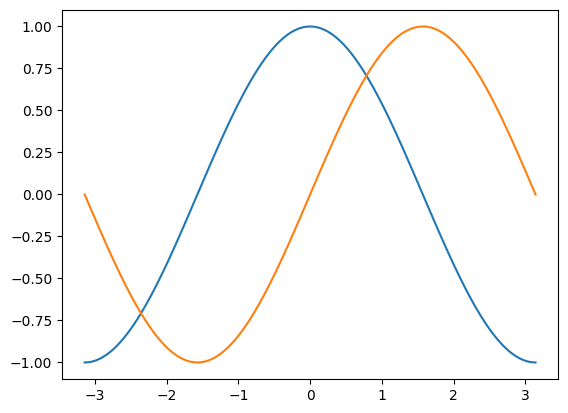

In [18]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(-np.pi, np.pi, 256, endpoint=True)
C, S = np.cos(X), np.sin(X)

plt.plot(X, C)
plt.plot(X, S)

plt.show()

C:\Users\29395\AppData\Local\Temp\ipykernel_51108\425896030.py:5: RuntimeWarning: invalid value encountered in arccos
  C, S, T, A = np.cos(X), np.sin(X), np.arctan(X), np.arccos(X)


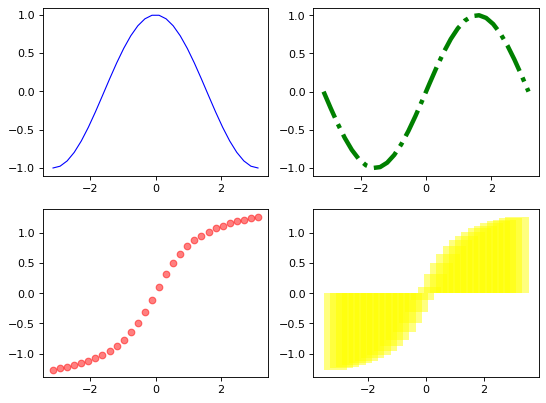

In [19]:
plt.figure(figsize=(8, 6), dpi=80)


X = np.linspace(-np.pi, np.pi, 30, endpoint=True)
C, S, T, A = np.cos(X), np.sin(X), np.arctan(X), np.arccos(X)

plt.subplot(2, 2, 1)
# 绘制余弦曲线，使用蓝色的、连续的、宽度为 1 （像素）的线条
plt.plot(X, C, color="blue", linewidth=1.0, linestyle="-")

plt.subplot(2, 2, 2)
# 绘制正弦曲线，使用绿色的、连续的、宽度为 1 （像素）的线条
plt.plot(X, S, color="green", linewidth=4.0, linestyle="-.")

plt.subplot(2, 2, 3)
plt.scatter(X, T, color='red', alpha=0.5)

plt.subplot(2, 2, 4)
plt.bar(X, T, color="yellow", alpha=0.5)

# 在屏幕上显示
plt.show()

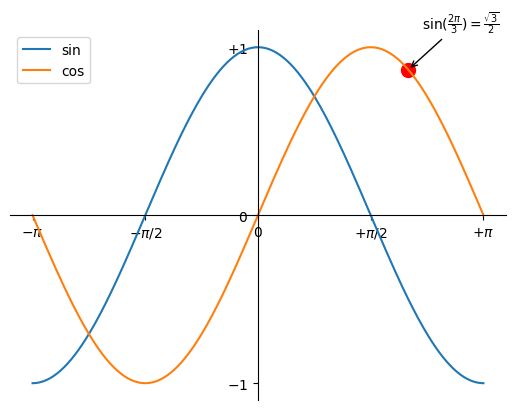

In [20]:
X = np.linspace(-np.pi, np.pi, 256, endpoint=True)
C, S = np.cos(X), np.sin(X)

plt.plot(X, C, label = 'sin')
plt.plot(X, S, label='cos')

# 修改标签
plt.xticks(
    [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi],
    [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$+\pi/2$", r"$+\pi$"],
)

plt.yticks([-1, 0, +1], [r"$-1$", r"$0$", r"$+1$"])

# 修改坐标轴位置
ax = plt.gca()
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
ax.xaxis.set_ticks_position("bottom")
ax.spines["bottom"].set_position(("data", 0))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("data", 0))

# 显示图例
plt.legend(loc="upper left")

# 标注
t = 2 * np.pi / 3
plt.scatter(
    [
        t,
    ],
    [
        np.sin(t),
    ],
    s=100,
    color="red",
)
plt.annotate(
    r"$\sin(\frac{2\pi}{3})=\frac{\sqrt{3}}{2}$",
    xy=(t, np.sin(t)),
    xycoords="data",
    xytext=(+10, +30),
    textcoords="offset points",
    arrowprops= dict(arrowstyle = "->"),
)


plt.show()

# Scipy
> an open-source software for mathematics, science, and engineering.
## Document
https://docs.scipy.org/doc/scipy/reference/index.html
## constants

In [21]:
import scipy
import scipy.constants
print(dir(scipy.constants))

print(scipy.constants.Avogadro)

['Avogadro', 'Boltzmann', 'Btu', 'Btu_IT', 'Btu_th', 'ConstantWarning', 'G', 'Julian_year', 'N_A', 'Planck', 'R', 'Rydberg', 'Stefan_Boltzmann', 'Wien', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_codata', '_constants', '_obsolete_constants', 'acre', 'alpha', 'angstrom', 'arcmin', 'arcminute', 'arcsec', 'arcsecond', 'astronomical_unit', 'atm', 'atmosphere', 'atomic_mass', 'atto', 'au', 'bar', 'barrel', 'bbl', 'blob', 'c', 'calorie', 'calorie_IT', 'calorie_th', 'carat', 'centi', 'codata', 'constants', 'convert_temperature', 'day', 'deci', 'degree', 'degree_Fahrenheit', 'deka', 'dyn', 'dyne', 'e', 'eV', 'electron_mass', 'electron_volt', 'elementary_charge', 'epsilon_0', 'erg', 'exa', 'exbi', 'femto', 'fermi', 'find', 'fine_structure', 'fluid_ounce', 'fluid_ounce_US', 'fluid_ounce_imp', 'foot', 'g', 'gallon', 'gallon_US', 'gallon_imp', 'gas_constant', 'gibi', 'giga', 'golden', 'golden_ratio', 'grain', '

## optimizer

In [22]:
from math import cos

def eqn(x):
    return x + cos(x)

myroot = scipy.optimize.root_scalar(eqn, method='newton', x0=0.1)

print(myroot)

      converged: True
           flag: converged
 function_calls: 10
     iterations: 5
           root: -0.7390851332151607


C:\Users\29395\AppData\Local\Temp\ipykernel_51108\144516694.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return x + cos(x)


In [23]:
def eqn(x):
    return (x[0]-3)**2 + (x[1]-1)**2

scipy.optimize.minimize(eqn, x0=[0, 0], method='CG')

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 4.9545506515086484e-14
       x: [ 3.000e+00  1.000e+00]
     nit: 1
     jac: [ 4.372e-07  1.557e-07]
    nfev: 9
    njev: 3

## Graph

In [24]:
from scipy.sparse.csgraph import connected_components, dijkstra, floyd_warshall
from scipy.sparse import csr_matrix

arr = np.array([[0, 1, 1], 
                [1, 0, 1111], 
                [2, 1111, 0]])

newarr = csr_matrix(arr)

print(connected_components(newarr))
print(dijkstra(newarr, return_predecessors=True, indices=2))
print(floyd_warshall(newarr, return_predecessors=True))

(1, array([0, 0, 0]))
(array([2., 3., 0.]), array([    2,     0, -9999]))
(array([[0., 1., 1.],
       [1., 0., 2.],
       [2., 3., 0.]]), array([[-9999,     0,     0],
       [    1, -9999,     0],
       [    2,     0, -9999]]))


## statistics
### 随机变量相关

连续随机变量对象有下列方法：
- rvs：采样
- pdf：密度函数
- cdf：累积分布函数
- sf：残存函数
- ppf：累积分布的逆
- isf：残存函数的逆
- fit：最大似然估计求参数

离散分布的简单方法大多数与连续分布很类似，但是pdf被更换为密度函数pmf。

In [25]:
# 从常用分布中采样
from scipy import stats
rv = stats.norm(
    loc=0,
    scale=1
)
print(rv.rvs(size=10))
print(rv.pdf(1))

data = stats.norm.rvs(loc=114, scale=514, size=1000000)
print(stats.norm.fit(data))

[-1.14164425 -0.31648311 -0.49599835  1.64242901  1.2215638   0.89229292
 -1.25841675  0.73553599 -1.01464565 -0.06207634]
0.24197072451914337
(113.88615581885283, 513.6050630022994)


### 假设检验
常用的如下：
- 单样本均值检验
- 两独立样本均值检验
    - 方差相等
    - 方差不相等
    - 检验方差
- 配对样本均值检

In [26]:
from scipy.stats import ttest_ind, ttest_1samp, levene, ttest_rel
import random

v1 = np.random.normal(size=1000)
v2 = np.random.normal(loc=1, size=1000)

# 单总体方差
res = ttest_1samp(v1, 0)
print(res)

# 两独立总体
res = ttest_ind(v1, v2, equal_var=True)
print(res)

# 两总体方差
res = levene(v1, v2)
print(res)

v_pair = [i + random.uniform(-1, 1) for i in v1]
# 配对样本均值
res= ttest_rel(v1, v_pair)
print(res)

TtestResult(statistic=1.8777443468618764, pvalue=0.06070729140870164, df=999)
TtestResult(statistic=-21.74841367971664, pvalue=2.6658835095976347e-94, df=1998.0)
LeveneResult(statistic=1.6086812381797118, pvalue=0.2048250402254886)
TtestResult(statistic=-0.5681001349820931, pvalue=0.5700946375738662, df=999)


# Pytorch
- 拥有类似于NumPy的张量计算系统，能在GPU等硬件上加速
- 自动微分系统的计算图在运行中构建（即动态图系统，区别于tensorflow先定义再建图的静态图系统）

动态图带来的好处在具有复杂控制条件的网络中尤其明显。例如，pytorch可以直接进行如下实现：
```python
def forward(self, x)
    for i in range(5):
        cond = random.randint(1, 5)
        if cond == 1:
            x = self.fc1(x)
        elif cond == 2:
            x = self.fc2(2)
        #.....
    return x
```
而使用tensorflow则需要使用tf.cond()进行多层嵌套


## Pytorch模型训练八股文
```python
class MyDataset(Dataset):
    def __init__(self, *args):
    
    def __getitem__(self, index):

    def __len__(self)

dataset = MyDataset(*args)
dataloader = DataLoader(dataset, *args)

class Model(nn.Modules):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return output

model = Model(*args)

lossfn = Loss()
optimizer = Optimizer(model.parameters(), lr=LEARNING_RATE)

for epoch_num in range(EPOCH):
    for (data, label) in dataloader:
        output = model(data)
        loss = lossfn(output, label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

torch.save(model, MODEL_SAVE_PATH)

```

## Pytorch的模型定义
pytorch中所有神经网络模型都由 torch.nn.Module 派生得到。在实现自己的模型时，绝大多数情况下只需要重写__init__, forward两个方法。

In [27]:
import torch

class TestModel(torch.nn.Module):
    def __init__(self):
        super(TestModel, self).__init__()
        # 简写：super().__init__()
        self.layer = torch.nn.Linear(5, 2)

    def forward(self, data):
        return(self.layer(data))




## Pytoch梯度计算与模型优化

In [28]:
test_model = TestModel()
data = torch.rand((1, 5))
y = test_model(data)

optimizer = torch.optim.SGD(test_model.parameters(), lr=1)
loss_fn = torch.nn.MSELoss()

print("-------------------\nbefore loss backward:\n")
print(test_model.layer._parameters["weight"])
print(test_model.layer._parameters["weight"].grad)

loss = loss_fn(torch.randn((1, 2)), y)
loss.backward()

print("-------------------\nafter loss backward:\n")
print(test_model.layer._parameters["weight"])
print(test_model.layer._parameters["weight"].grad)
print(test_model.layer._parameters["weight"].grad.shape)

print(loss.grad_fn)
print(loss.grad_fn.next_functions)

optimizer.step()

print("-------------------\nafter optimize:")

print(test_model.layer._parameters["weight"])
print(test_model.layer._parameters["weight"].grad)
print(test_model.layer._parameters["weight"].grad.shape)

optimizer.zero_grad()
print("-------------------\nafter zerograd:")

print(test_model.layer._parameters["weight"])
print(test_model.layer._parameters["weight"].grad)


with torch.no_grad():
    loss = loss_fn(torch.randn((1, 2)), y)
    print(loss.grad_fn)

-------------------
before loss backward:

Parameter containing:
tensor([[ 0.1111, -0.0884, -0.0818,  0.1189, -0.0963],
        [ 0.0981,  0.2345,  0.2889, -0.1838,  0.1318]], requires_grad=True)
None
-------------------
after loss backward:

Parameter containing:
tensor([[ 0.1111, -0.0884, -0.0818,  0.1189, -0.0963],
        [ 0.0981,  0.2345,  0.2889, -0.1838,  0.1318]], requires_grad=True)
tensor([[-0.3485, -0.4674, -0.0193, -0.7258, -0.5310],
        [ 0.9130,  1.2245,  0.0506,  1.9013,  1.3910]])
torch.Size([2, 5])
((None, 0), (<AddmmBackward0 object at 0x00000204856897B0>, 0))
-------------------
after optimize:
Parameter containing:
tensor([[ 0.4596,  0.3790, -0.0624,  0.8447,  0.4347],
        [-0.8149, -0.9900,  0.2383, -2.0851, -1.2592]], requires_grad=True)
tensor([[-0.3485, -0.4674, -0.0193, -0.7258, -0.5310],
        [ 0.9130,  1.2245,  0.0506,  1.9013,  1.3910]])
torch.Size([2, 5])
-------------------
after zerograd:
Parameter containing:
tensor([[ 0.4596,  0.3790, -0.062

## Pytorch数据集

In [29]:
import torch
from torch.utils.data import Dataset, DataLoader
from tokenizers import Tokenizer
import json
import threading
from tqdm import tqdm
import math

tokenizer = Tokenizer.from_file("tokenizer/tokenizer.json")
tokenizer.enable_padding(length=256)

def deal_segment(inputlist, savelist):
    for item in inputlist:
        tmp_dict = json.loads(item)
        savelist.append(
            (
                torch.tensor(tokenizer.encode(tmp_dict["content"]).ids[:256]),
                torch.tensor(
                    [1 - tmp_dict["label"], tmp_dict["label"]], dtype=torch.float32
                ),
            )
        )

class MyDataSet(Dataset):
    def __init__(self, file: str):
        self.data = []
        with open(file, "r", encoding='utf-8') as fin:
            inputlist = list(fin)
            tlist = [threading.Thread(target=deal_segment, args = (inputlist[1000*i:1000*(i+1)], self.data,)) for i in range(math.ceil(len(inputlist)/1000))]
            for t in tqdm(tlist):
                t.start()
            for t in tlist:
                t.join()
        fin.close()
                
    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return len(self.data)

train_set = MyDataSet(file="dataset/train.jsonl")
test_set = MyDataSet(file="dataset/test.jsonl")

100%|██████████| 20/20 [00:03<00:00,  5.47it/s]


In [30]:
train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=32, shuffle=True)

for data, label in train_loader:
    print(data)
    print(label)
    break

tensor([[2236,  610,  173,  ...,    0,    0,    0],
        [ 804,  731,  337,  ...,    0,    0,    0],
        [ 258,  141,   68,  ...,    0,    0,    0],
        ...,
        [ 818,    0,   87,  ...,    0,    0,    0],
        [  76,  200, 4261,  ...,    0,    0,    0],
        [  44, 1095, 1564,  ...,    0,    0,    0]])
tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.]])


## 训练实例

In [31]:
import torch
import torch.nn as nn

# 模型定义
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings=50000, embedding_dim=64)
        self.layer1 = nn.Linear(64*256, 64*32)
        self.ac1 = nn.ReLU()
        self.layer2 = nn.Linear(64*32, 16*16)
        self.ac2 = nn.ReLU()
        self.out = nn.Linear(16*16, 2)
        
    def forward(self, data):
        hidden = self.emb(data).reshape(-1, 64*256)
        h1 = self.ac1(self.layer1(hidden))
        h2 = self.ac2(self.layer2(h1))
        return self.out(h2)
    
    
model = MyModel()

In [32]:
from torch.optim import SGD
import torch.nn as nn

# 损失函数和优化器定义
loss_fn = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=1e-3)

In [36]:
import wandb
import numpy as np

# 训练
wandb.finish()
wandb.init(
    # set the wandb project where this run will be logged
    project="summer_guide",
    # track hyperparameters and run metadata
    config={
        "learning_rate": 1e-3,
        "architecture": "MLP",
        "dataset": "amazon-plarity",
        "epochs": 3,
    },
)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.device('cuda:0')
model.to(device)
# model.cuda()
for i in range(wandb.config['epochs']):
    for batch, (X, y) in enumerate(train_loader):
        pred = model(X.to(device))
        loss = loss_fn(pred, y.to(device))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 20 == 0:
            wandb.log(
                {
                    "loss": loss,
                    "acc": np.mean((torch.argmax(pred.cpu(), -1) == torch.argmax(y.cpu(), -1)).numpy()),
                }
            )
    torch.save(model.state_dict(), "result/model.pt")
wandb.finish()

acc,▃▃▇▂▇▅▄▇▅▂▂█▇▂▃▄▄▄▃▅▄▃▇▂▅▄▁▅▂▇▆▃▃▂▂▂▃▅▃▃
loss,▆▅▃▆▂▅▆▄▆█▆▁▄▇▅▅▆▆▆▆▆▆▄▇▄█▇▇▅▃▄▆▅█▅▆▇▇▅▅
acc,0.53125
loss,0.62982


In [35]:
# 推理
model = MyModel()
model.load_state_dict(torch.load('result/model.pt'))
import torch
from tokenizers import Tokenizer


# model = torch.load(
#     "result/model.pt", map_location=torch.device("cpu"), weights_only=False
# )
tokenizer = Tokenizer.from_file("tokenizer/tokenizer.json")
tokenizer.enable_padding(length=256)
sentence = "I think this is a bad product."
# sentence = "I bought this charger in Jul 2003 and it worked OK for a while. The design is nice and convenient. However, after about a year, the batteries would not hold a charge. Might as well just get alkaline disposables, or look elsewhere for a charger that comes with batteries that have better staying power."
# sentence = "My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I'm in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life's hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing \"Who was that singing ?\""
ids = torch.tensor(tokenizer.encode(sentence).ids)
print("origin sentence:", tokenizer.decode(ids.tolist()), '\n')
model.eval()
with torch.no_grad():
    out = torch.nn.functional.softmax(model(ids), dim=-1)
    print("probability:", out, '\n')
    print("class:", torch.argmax(out).item(), '\n')

origin sentence: I think this is a bad product . 

probability: tensor([[0.4286, 0.5714]]) 

class: 1 



# 作业
编写脚本，实现RNN文本情感分类任务，要求如下：
- 使用GRU或LSTM块作为RNN块（推荐手写，但也可以使用pytorch内置的类，如果想使用请阅读pytorch文档）
- RNN能够实现不定长输入，即根据输入长度判断RNN的循环次数
- 分类正确率超过80%
- 能够使用plt或wandb绘制训练过程的loss、train accuracy和test accuracy曲线
- 能够保存训练后的神经网络参数，以及加载并使用该参数进行推理